In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
sunspot_ts = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
sunspot_ts.index = sunspot_ts['time'].values
sunspot_ts.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)
sunspot_ts.rename({'value': 'sunspot.year'}, axis=1, inplace=True)

In [3]:
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage_ts = wage.astype(int)

In [4]:
energy_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv',
                        sep=',', parse_dates=['Date'], dayfirst=False, index_col='Date')

energy_df = energy_df[energy_df.id == 2]
energy_df = energy_df['2010-01-01':'2015-05-13']
energy_df.dropna(axis=1, inplace=True)

energy_ts = energy_df.EnergyConsumption.astype(int)

In [5]:
def get_density_forecast(ts, horizon, base_alg, base_params={}, bins='auto', omega=None, fittedvalues=False):
    """
    Returns a list of density dictionaries {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    horizon : int
        The horizon to forecast.
    base_alg : {ExponentialSmoothing, SimpleExpSmoothing, Holt}
        The name of base algoritm for making density forecast.
    base_params : dict
        A Dictionary with base algorithm parameters.
    bins: int or sequence of scalars or str, optional
        Define how to calculate bins.
    fittedvalues: bool
        Include fitted values in density dictionaries or not.
    """
    
    # my experiment 
    if omega:
        min_bound = omega[0]
        max_bound = omega[-1]
        bins = np.linspace(min_bound, max_bound, bins + 1)
        
    
    alg = base_alg(ts, **base_params).fit()
    
    if fittedvalues:
        alg_preds = alg.predict(start=0, end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(len(ts) + horizon)]
    else:
        alg_preds = alg.predict(start=len(ts), end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(horizon)]
    
    for i in range(len(alg_preds)):
        density_dicts[i]['dotted_forecast'] = alg_preds[i]
        
        current_density = alg.resid + alg_preds[i]
        density_dicts[i]['probs'], density_dicts[i]['bins'] = np.histogram(current_density, bins=bins, density=True)
    
    return density_dicts

In [6]:
def plot_density_forecast(ts, delay, base_alg, ax=None, **kwargs):
        
    density_dict = get_density_forecast(ts, delay, base_alg, **kwargs)[delay - 1]

    left_edges = density_dict['bins'][:-1]

    colors = []
    for i in range(len(left_edges) - 1):
        if left_edges[i] < density_dict['dotted_forecast'] < left_edges[i+1]:
            colors.append('coral')
        else:
            colors.append('royalblue')
    
    alg_name = str(base_alg)[str(base_alg).find('model.') + 6:-2]
    
    if ax:
        ax.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        ax.set_title(f'{alg_name}: density forecast with delay={delay}')
    else:
        plt.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        plt.title(f'{alg_name}: density forecast with delay={delay}')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


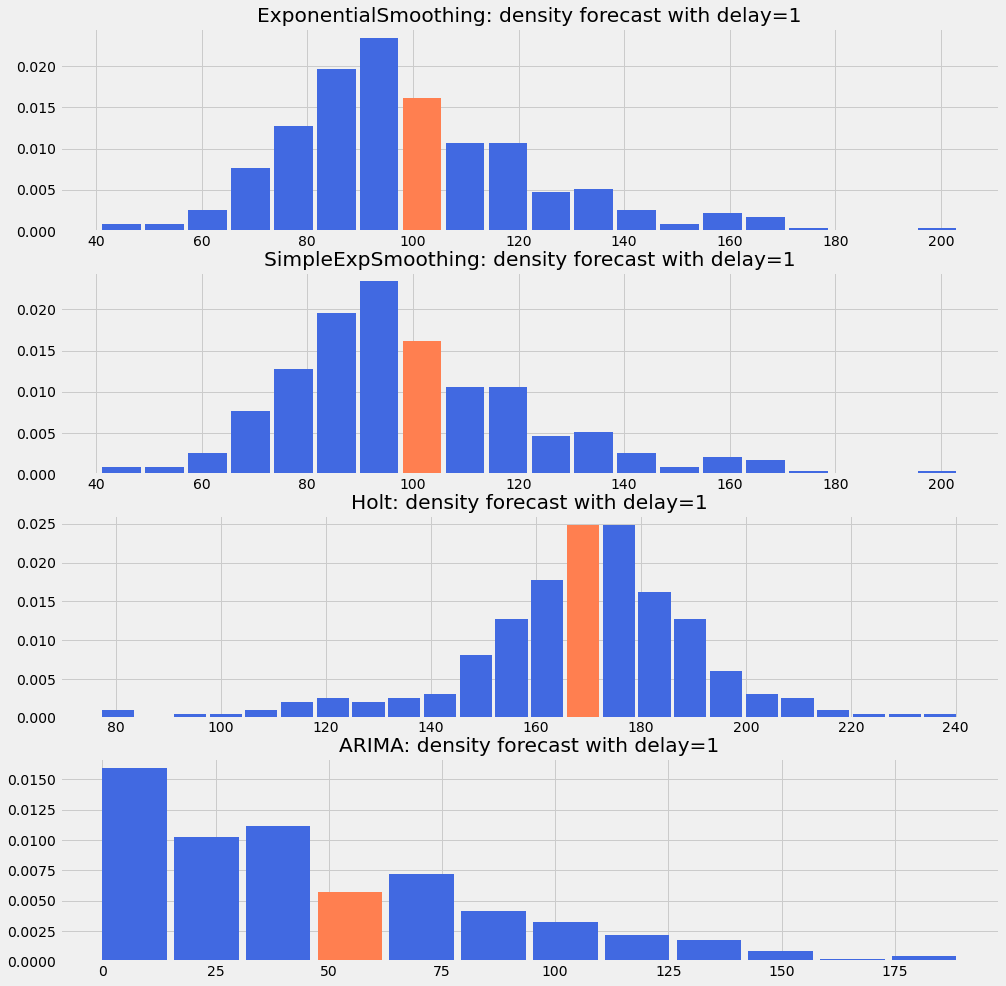

In [7]:
fig, ax = plt.subplots(4, figsize=(15,16))

for i, alg in enumerate([ExponentialSmoothing, SimpleExpSmoothing, Holt, ARIMA]):
    plot_density_forecast(sunspot_ts.values, 1, alg, ax=ax[i], bins='auto')

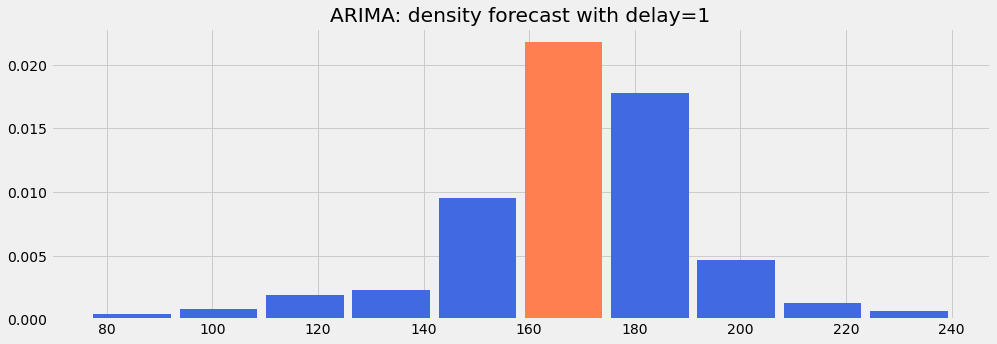

In [8]:
plt.figure(figsize=(15,5))
plot_density_forecast(sunspot_ts.values, 1, ARIMA, base_params={'order': (1, 2, 0)}, bins=10)

In [9]:
def get_omega(ts):
#     # my experiment 
#     min_w = (preds[0]['bins'][0] + preds[0]['bins'][1]) / 2
#     max_w = (preds[0]['bins'][-2] + preds[0]['bins'][-1]) / 2
    
    min_o = int(np.floor(min(ts)))
    max_o = int(np.ceil(max(ts)))
    return list(range(min_o, max_o + 1))

In [10]:
def brier_loss(y_true, density_dict):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dict : dict
        Dict with bins and probabilities information.
    """
    bins_number = density_dict['probs'].size
    bins_true = [0] * bins_number

    for i in range(bins_number):
        if density_dict['bins'][i] <= y_true <= density_dict['bins'][i + 1]:
            bins_true[i] = 1
            break
            
#     brier_loss = np.sum(np.diff(density_dict['bins']) * (density_dict['probs'] - bins_true)**2)
    brier_loss = np.sum((density_dict['probs'] - bins_true)**2)
    
    if np.sum(bins_true) == 0:
        brier_loss += 1 # += np.diff(density_dict['bins']).mean() * 1
        
    return brier_loss

In [11]:
def get_generalized_loss(y_true, density_dicts, loss_function):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dicts : dict or array-like of dicts
        Dicts with bins and probabilities information.
    """
    if type(density_dicts) == dict:
        density_dicts = [density_dicts]
    
    losses = [np.nan] * len(density_dicts)
    
    for density_dict_count, density_dict in enumerate(density_dicts):
        losses[density_dict_count] = loss_function(y_true, density_dict)
        
    return np.array(losses)

In [12]:
def avoid_overflowing(base, power_array):
    maximum = np.max(power_array)
    minimum = np.min(power_array)
    
    pmax = -np.log(base)/np.log(2) * maximum
    pmin = -np.log(base)/np.log(2) * minimum
    
    if np.abs(pmax-pmin) > 2097:
        print('Overflow is imminent. Further calculations are not advised')
        return base ** power_array
    power_shift = abs((51+pmin+pmax)/2)
    power_shift = power_shift + min(0, pmin - power_shift + 1023)
    
    power_array = power_array - np.abs(power_shift * np.log(2) / np.log(base))
    
    return base ** power_array

In [13]:
def get_generalized_prediction(ts, preds, omega, weights, loss_function, eta=1):
    generalized_predictions = []
    
    for w in omega:
        losses = get_generalized_loss(w, preds, loss_function)
        exp_losses = avoid_overflowing(np.e, -eta * losses)
        generalized_predictions.append(-(1 / eta) * np.log(np.sum(weights * exp_losses)))
        
    return np.array(generalized_predictions)

In [14]:
from scipy.optimize import fsolve

def s_equation(s, generalized_predictions, m=2):
    return np.sum([max(x,0) for x in s - generalized_predictions]) - m

In [15]:
def substitution_function(generalized_predictions, s, m=2):
    predictions = [max(x,0) / m for x in s - generalized_predictions]
    return predictions

In [16]:
def get_AA_density(omega_and_predictions, bins):
    probs = [0] * (len(bins) - 1)
    for i in range(len(bins) - 1):
        for omega, pred in omega_and_predictions:
            if bins[i] <= omega < bins[i + 1]:
                probs[i] += pred
    return np.array(probs) / np.array(np.diff(bins))

In [17]:
def update_weights(weights, losses, eta=1):
    exp_losses = avoid_overflowing(np.e, -eta * np.array(losses))
    new_weights = weights * exp_losses
    return new_weights / (np.sum(new_weights))

In [18]:
def aggregating_algorithm(ts, horizon, base_alg_dict, bins=10, loss_function=brier_loss, weights=None, eta=1):
    """
    Returns density dictionary {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    delay : int
        The delay to forecast.
    base_alg_dict : dict
        The dictionary with the names of base algoritms and their params:
        base_alg {ExponentialSmoothing, SimpleExpSmoothing, Holt} - name of base algorithm.
        base_alg_params : dict - a dictionary of base algorithm's parameters.
    loss_function : function
        The loss function of aggregating algorithm.
    """
    T = len(ts)
    K = len(base_alg_dict)
    
    AA_preds = [{} for i in range(T + horizon)]
    BA_preds = np.array([{} for i in range((T + horizon) * K)]).reshape(K, T + horizon) 
    
    if not weights:
        weights = np.full(K, 1/K)
    
    omega = get_omega(ts) # здесь в Omega прогнозы не учитываются
    
    i = 0
    for base_alg, base_alg_params in base_alg_dict.items():
        BA_preds[i] = get_density_forecast(ts, horizon, base_alg, base_params=base_alg_params,
                                           bins=bins, omega=omega, fittedvalues=True)
        i += 1
        
    losses, prev_losses = None, None
        
    for t in tqdm(range(T + horizon)):
        preds = BA_preds[:, t]
        
        if not prev_losses:     
            prev_losses = [loss_function(ts[t], pred) for pred in preds]  # cheat
              
        generalized_predictions = get_generalized_prediction(ts[:t], preds, omega,
                                                             weights, loss_function, eta)
        
        #solving the equation to find s
        s_init = np.max(generalized_predictions)
        s = fsolve(s_equation, s_init, args=generalized_predictions)
        
        #get real prediction with substitution function
        AA_preds[t]['bins'] = BA_preds[:, t][0]['bins']
        real_predictions = substitution_function(generalized_predictions, s)
        omega_and_predictions = list(zip(omega, real_predictions))
        AA_preds[t]['probs'] = get_AA_density(omega_and_predictions, AA_preds[t]['bins'])
        
        #update weights 
        if t < T:
            losses = [loss_function(ts[t], pred) for pred in preds]
            weights = update_weights(weights, losses, eta)

            prev_losses = losses
    
    return AA_preds

In [19]:
omega = get_omega(sunspot_ts.values)

Holt_preds = get_density_forecast(sunspot_ts.values, 3, Holt,
                                  bins=10, omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(sunspot_ts.values, 3, SimpleExpSmoothing,
                                 bins=10, omega=omega, fittedvalues=True)

AA_preds = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}}, bins=10)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


  0%|          | 0/292 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [20]:
Holt_losses = []
SES_losses = []
AA_losses = []
for i in range(len(sunspot_ts.values)):
    Holt_losses.append(brier_loss(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses.append((brier_loss(sunspot_ts.values[i], SES_preds[i])))
    AA_losses.append((brier_loss(sunspot_ts.values[i], AA_preds[i])))

Average Holt Loss: 0.9611774192732604
Average SES Loss: 0.9682709048467827
Average AA Loss: 0.9547724897266034


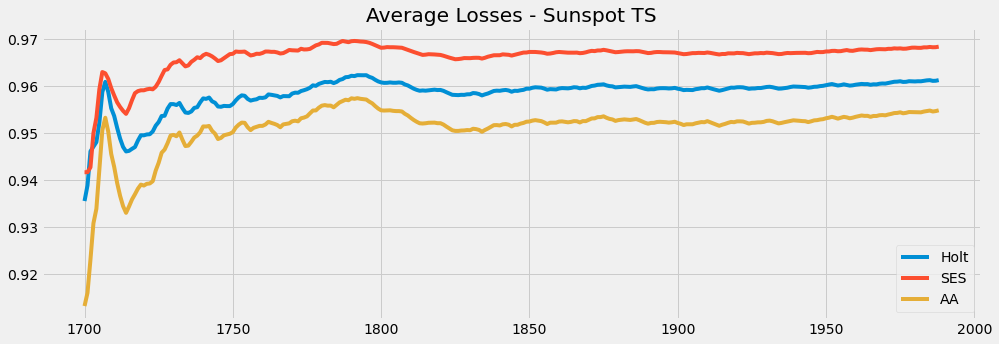

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(sunspot_ts.index, np.cumsum(Holt_losses) / list(range(1, len(sunspot_ts.values) + 1)))
plt.plot(sunspot_ts.index, np.cumsum(SES_losses) / list(range(1, len(sunspot_ts.values) + 1)))
plt.plot(sunspot_ts.index, np.cumsum(AA_losses) / list(range(1, len(sunspot_ts.values) + 1)))
plt.title('Average Losses - Sunspot TS')
plt.legend(['Holt', 'SES', 'AA'], loc='lower right');

print(f'Average Holt Loss: {np.mean(Holt_losses)}')
print(f'Average SES Loss: {np.mean(SES_losses)}')
print(f'Average AA Loss: {np.mean(AA_losses)}')

In [22]:
omega = get_omega(wage_ts.values)

Holt_preds = get_density_forecast(wage_ts.values, 3, Holt,
                                  bins=10, omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(wage_ts.values, 3, SimpleExpSmoothing,
                                 bins=10, omega=omega, fittedvalues=True)

AA_preds = aggregating_algorithm(wage_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}}, bins=10)

Holt_losses = []
SES_losses = []
AA_losses = []
for i in range(len(wage_ts.values)):
    Holt_losses.append(brier_loss(wage_ts.values[i], Holt_preds[i]))
    SES_losses.append((brier_loss(wage_ts.values[i], SES_preds[i])))
    AA_losses.append((brier_loss(wage_ts.values[i], AA_preds[i])))

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


  0%|          | 0/292 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Average Holt Loss: 0.9569211051904591
Average SES Loss: 0.9553159024288972
Average AA Loss: 0.948110552855029


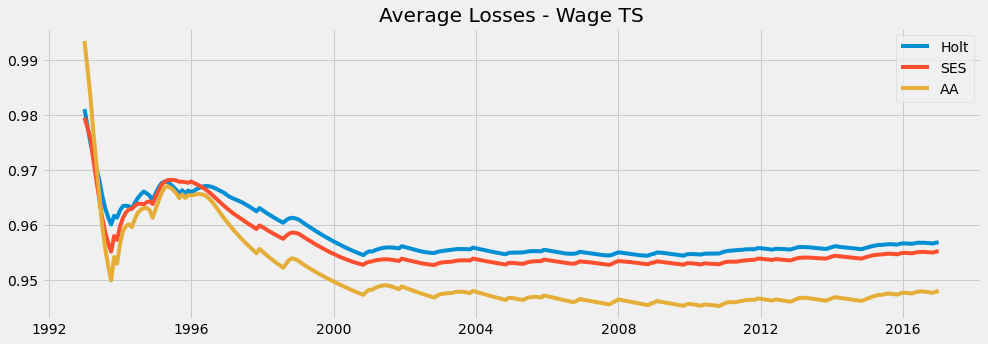

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(wage_ts.index, np.cumsum(Holt_losses) / list(range(1, len(wage_ts.values) + 1)))
plt.plot(wage_ts.index, np.cumsum(SES_losses) / list(range(1, len(wage_ts.values) + 1)))
plt.plot(wage_ts.index, np.cumsum(AA_losses) / list(range(1, len(wage_ts.values) + 1)))
plt.title('Average Losses - Wage TS')
plt.legend(['Holt', 'SES', 'AA'], loc='upper right');

print(f'Average Holt Loss: {np.mean(Holt_losses)}')
print(f'Average SES Loss: {np.mean(SES_losses)}')
print(f'Average AA Loss: {np.mean(AA_losses)}')

In [24]:
# T = sunspot_ts.size
# ts = sunspot_ts.values
# delay = 3
# K = 2

# omega = get_omega(ts)

# BA_preds = np.array([{}]*(T + delay)*K).reshape(K, T + delay) 

# i = 0
# for base_alg, base_alg_params in {Holt: {}, SimpleExpSmoothing: {}}.items():
#     BA_preds[i] = get_density_forecast(ts, delay, base_alg, base_params=base_alg_params,
#                                        bins=10, omega=omega, fittedvalues=True)
#     i += 1

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [25]:
# np.sum(np.diff(BA_preds[:, 0][0]['bins']) * BA_preds[:, 0][0]['probs'])

0.9999999999999999

In [26]:
# losses = [brier_loss(20, pred) for pred in BA_preds[:, 0]]
# weights = np.full(2, 1/2)
# losses, weights

([0.9711696924534989, 0.9747526408983269], array([0.5, 0.5]))

In [27]:
# losses = [brier_loss(20, pred) for pred in BA_preds[:, 0]]
# weights = np.full(2, 1/2)
# losses, weights

# generalized_predictions = get_generalized_prediction(ts, BA_preds[:, 0], omega,
#                                                      weights, brier_loss, eta=1)
# generalized_predictions

array([19.55243326, 19.55243326, 19.55243326, 19.55243326, 19.55243326,
       19.55243326, 19.55243326, 19.55243326, 19.55243326, 19.55243326,
       19.55243326, 19.55243326, 19.55243326, 19.55243326, 19.55243326,
       19.55243326, 19.55243326, 19.55243326, 19.55243326, 19.55243326,
       19.62117383, 19.62117383, 19.62117383, 19.62117383, 19.62117383,
       19.62117383, 19.62117383, 19.62117383, 19.62117383, 19.62117383,
       19.62117383, 19.62117383, 19.62117383, 19.62117383, 19.62117383,
       19.62117383, 19.62117383, 19.62117383, 19.62117383, 19.65906085,
       19.65906085, 19.65906085, 19.65906085, 19.65906085, 19.65906085,
       19.65906085, 19.65906085, 19.65906085, 19.65906085, 19.65906085,
       19.65906085, 19.65906085, 19.65906085, 19.65906085, 19.65906085,
       19.65906085, 19.65906085, 19.65906085, 19.67049512, 19.67049512,
       19.67049512, 19.67049512, 19.67049512, 19.67049512, 19.67049512,
       19.67049512, 19.67049512, 19.67049512, 19.67049512, 19.67

In [28]:
# s_init = np.max(generalized_predictions)
# s = fsolve(s_equation, s_init, args=generalized_predictions)
# s

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([19.63720431])

In [29]:
# omega_and_pred = list(zip(omega, substitution_function(generalized_predictions, s)))

# get_AA_density(omega_and_pred, BA_preds[:, 0][0]['bins'])

array([0.04438275, 0.00797327, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [30]:
# np.sum(np.diff(BA_preds[:, 0][0]['bins']) * np.array(get_AA_density(omega_and_pred, BA_preds[:, 0][0]['bins'])))

0.9999999999999662